In [1]:
import copy
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize

from scipy import interpolate
from scipy import ndimage as ndi

import skimage.data
import skimage.filters
import skimage.transform

# TODO: figure out a better way of doing this
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
import register_nonrigid
import utils

im = skimage.data.astronaut()
ORIG_SIZE = (60, 75)
im = np.uint8(255 * skimage.transform.resize(im, ORIG_SIZE))


/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


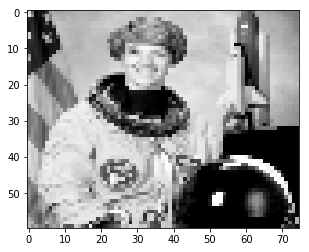

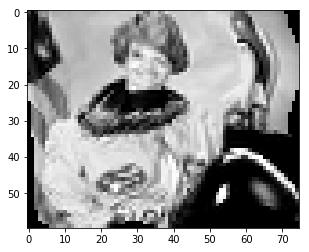

In [2]:

class ImageDeformer:
    def __init__(self, Image, samp_space=5, sigma=10, lam=.1):
        self.Image = Image
        self.sigma = sigma
        self.lam = lam

        # large image grid
        x_range = np.arange(0, Image.shape[1])
        y_range = np.arange(0, Image.shape[0])

        xx, yy = np.meshgrid(x_range, y_range)
        xin, yin = xx.flatten(), yy.flatten()
        x_data_all = np.array([yin, xin]).T

        # small sampled grid
        x_range_samp = np.linspace(
            0, Image.shape[1] - 1, Image.shape[1] / samp_space)
        y_range_samp = np.linspace(
            0, Image.shape[0] - 1, Image.shape[0] / samp_space)

        xx_samp, yy_samp = np.meshgrid(x_range_samp, y_range_samp)
        xin_samp, yin_samp = xx_samp.flatten(), yy_samp.flatten()
        xx_samp, yy_samp = np.meshgrid(x_range_samp, y_range_samp)
        xin_samp, yin_samp = xx_samp.flatten(), yy_samp.flatten()
        x_samp = np.array([yin_samp, xin_samp]).T
        self.x_samp = x_samp

        # design matrix
        self.H_samp = register_nonrigid.get_rbf_design_matrix(
            x_samp, x_samp, sigma=sigma)
        self.H_all = register_nonrigid.get_rbf_design_matrix(
            x_data_all, x_samp, sigma=sigma)
        
        # disp wts - init random
        self._w_x = np.random.randn(len(self.x_samp), 1)
        self._w_y = np.random.randn(len(self.x_samp), 1)
        
    @property
    def image(self):
        return self.Image
        
    @property
    def w_x(self):
        return self._w_x
        
    @property
    def w_y(self):
        return self._w_y

    @w_x.setter
    def w_x(self, w_x):
        self._w_x = w_x

    @w_y.setter
    def w_y(self, w_y):
        self._w_y = w_y
    
    def apply_deformation_from_wts(self):
        dx = np.dot(self.H_all, self._w_x)
        dy = np.dot(self.H_all, self._w_y)

        return self.apply_disps(dx, dy)

    def apply_random_deformation(self):
        x_disp_samp = 3 * np.random.randn(len(self.x_samp), 1)
        y_disp_samp = 3 * np.random.randn(len(self.x_samp), 1)

        self._w_x = register_nonrigid.solve_lst_sq_wt(
            self.H_samp, x_disp_samp, lam=self.lam)
        self._w_y = register_nonrigid.solve_lst_sq_wt(
            self.H_samp, y_disp_samp, lam=self.lam)

        dx = np.dot(self.H_all, self._w_x)
        dy = np.dot(self.H_all, self._w_y)

        return self.apply_disps(dx, dy)

    def apply_disps(self, dx, dy):
        im_interp = register_nonrigid.image_interp_warp(self.Image, dx, dy)
        return im_interp


# make a initial random deformation
re_init = True
if re_init:
    im_moving = im[:, :, 0]
    imdeform_init = ImageDeformer(im_moving, samp_space=12, sigma=10)
    im_fixed = imdeform_init.apply_random_deformation()

plt.figure(1)
plt.imshow(im_moving, cmap='gray')

plt.figure(2)
plt.imshow(im_fixed, cmap='gray')

plt.show()



/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


(30, 1) (60,)
param shape: (60,), sum: 0.0
ssd: 340376.0
param shape: (60,), sum: 0.1
ssd: 340150.01
param shape: (60,), sum: 0.1
ssd: 344014.01
param shape: (60,), sum: 0.1
ssd: 342461.01
param shape: (60,), sum: 0.1
ssd: 343248.01
param shape: (60,), sum: 0.1
ssd: 341662.01
param shape: (60,), sum: 0.1
ssd: 341859.01
param shape: (60,), sum: 0.1
ssd: 342340.01
param shape: (60,), sum: 0.1
ssd: 343511.01
param shape: (60,), sum: 0.1
ssd: 342001.01
param shape: (60,), sum: 0.1
ssd: 340893.01
param shape: (60,), sum: 0.1
ssd: 341663.01
param shape: (60,), sum: 0.1
ssd: 342768.01
param shape: (60,), sum: 0.1
ssd: 340138.01
param shape: (60,), sum: 0.1
ssd: 340940.01
param shape: (60,), sum: 0.1
ssd: 342084.01
param shape: (60,), sum: 0.1
ssd: 343585.01
param shape: (60,), sum: 0.1
ssd: 343382.01
param shape: (60,), sum: 0.1
ssd: 342910.01
param shape: (60,), sum: 0.1
ssd: 341501.01
param shape: (60,), sum: 0.1
ssd: 341219.01
param shape: (60,), sum: 0.1
ssd: 342043.01
param shape: (60,),

ssd: 343144.0481612376
param shape: (60,), sum: -0.45728347498075567
ssd: 341328.04691250867
param shape: (60,), sum: -0.45728347498075567
ssd: 341563.04762841394
param shape: (60,), sum: -0.45728347498075567
ssd: 342997.04571267136
param shape: (60,), sum: -0.45728347498075567
ssd: 340273.0477342021
param shape: (60,), sum: -0.45728347498075567
ssd: 341353.046049279
param shape: (60,), sum: -0.45728347498075567
ssd: 340879.0506827709
param shape: (60,), sum: -0.45728347498075567
ssd: 340557.0493120291
param shape: (60,), sum: -0.45728347498075567
ssd: 340436.04864094435
param shape: (60,), sum: -0.45728347498075567
ssd: 340514.0513456415
param shape: (60,), sum: -0.45728347498075567
ssd: 343082.04956314433
param shape: (60,), sum: -0.45728347498075567
ssd: 343000.0504056345
param shape: (60,), sum: -0.45728347498075567
ssd: 338861.0498841478
param shape: (60,), sum: -0.45728347498075567
ssd: 340153.04870346154
param shape: (60,), sum: -0.45728347498075567
ssd: 338795.0506481002
param 

param shape: (60,), sum: -0.7756422354622913
ssd: 334637.0351503806
param shape: (60,), sum: -0.7756422354622913
ssd: 334029.03436767525
param shape: (60,), sum: -0.7756422354622913
ssd: 339077.03469953634
param shape: (60,), sum: -0.7756422354622913
ssd: 336682.03320759116
param shape: (60,), sum: -0.7756422354622913
ssd: 333545.035876521
param shape: (60,), sum: -0.7756422354622913
ssd: 334510.0358688486
param shape: (60,), sum: -0.7756422354622913
ssd: 336039.0354430474
param shape: (60,), sum: -0.7756422354622913
ssd: 333658.03738437523
param shape: (60,), sum: -0.7756422354622913
ssd: 334942.03447629773
param shape: (60,), sum: -0.7756422354622913
ssd: 335060.03532496735
param shape: (60,), sum: -0.7756422354622913
ssd: 334910.03552035626
param shape: (60,), sum: -0.7756422354622913
ssd: 334811.0368235914
param shape: (60,), sum: -0.7756422354622913
ssd: 336287.0362895115
param shape: (60,), sum: -0.7756422354622913
ssd: 338075.0352950343
param shape: (60,), sum: -0.77564223546229

param shape: (60,), sum: -0.08375826868814042
ssd: 333963.020485864
param shape: (60,), sum: -0.08375826868814042
ssd: 333561.0210402829
param shape: (60,), sum: -0.08375826868814043
ssd: 334332.02075079683
param shape: (60,), sum: -0.08375826868814043
ssd: 334781.0205547438
param shape: (60,), sum: -0.08375826868814044
ssd: 336095.0207654078
param shape: (60,), sum: -0.08375826868814043
ssd: 338506.02029716066
param shape: (60,), sum: -0.08375826868814043
ssd: 336078.0184884724
param shape: (60,), sum: -0.08375826868814044
ssd: 333298.0200174909
param shape: (60,), sum: -0.08375826868814042
ssd: 333810.0207482102
param shape: (60,), sum: -0.08375826868814043
ssd: 331882.02070245455
param shape: (60,), sum: -0.08375826868814044
ssd: 334490.02035104774
param shape: (60,), sum: -0.08375826868814046
ssd: 334056.01953439804
param shape: (60,), sum: -0.08375826868814046
ssd: 335188.01768330374
param shape: (60,), sum: -0.08375826868814044
ssd: 332905.01945481286
param shape: (60,), sum: -0.

param shape: (60,), sum: -0.06507979523159209
ssd: 332121.0191383259
param shape: (60,), sum: -0.17441903195986627
ssd: 333887.01398846466
param shape: (60,), sum: -0.17441903195986627
ssd: 333887.01398846466
param shape: (60,), sum: -0.07441903195986628
ssd: 333184.01901789557
param shape: (60,), sum: -0.07441903195986628
ssd: 332824.01710208406
param shape: (60,), sum: -0.07441903195986628
ssd: 334926.01788677525
param shape: (60,), sum: -0.07441903195986625
ssd: 333354.01749132865
param shape: (60,), sum: -0.07441903195986628
ssd: 335781.01827374374
param shape: (60,), sum: -0.07441903195986625
ssd: 335012.0181826581
param shape: (60,), sum: -0.07441903195986628
ssd: 334654.0179515628
param shape: (60,), sum: -0.07441903195986625
ssd: 331118.0173736595
param shape: (60,), sum: -0.07441903195986628
ssd: 332640.0181333839
param shape: (60,), sum: -0.07441903195986628
ssd: 333205.0186585305
param shape: (60,), sum: -0.07441903195986628
ssd: 336723.01826666814
param shape: (60,), sum: -

param shape: (60,), sum: -0.06540098030726964
ssd: 334872.01817682374
param shape: (60,), sum: -0.06540098030726964
ssd: 334030.017630616
param shape: (60,), sum: -0.06540098030726961
ssd: 333888.01889582706
param shape: (60,), sum: -0.06540098030726962
ssd: 333510.0185249697
param shape: (60,), sum: -0.06540098030726962
ssd: 334834.0179722068
param shape: (60,), sum: -0.06540098030726962
ssd: 334304.01720772835
param shape: (60,), sum: -0.06540098030726962
ssd: 334073.0173154507
param shape: (60,), sum: -0.06540098030726964
ssd: 329494.01756695216
param shape: (60,), sum: -0.06540098030726964
ssd: 338158.0182493351
param shape: (60,), sum: -0.06540098030726964
ssd: 334329.0183910727
param shape: (60,), sum: -0.06540098030726964
ssd: 331197.01799854403
param shape: (60,), sum: -0.06540098030726961
ssd: 334949.017265884
param shape: (60,), sum: -0.06540098030726964
ssd: 334522.0168653445
param shape: (60,), sum: -0.06540098030726962
ssd: 332214.01696113055
param shape: (60,), sum: -0.06

param shape: (60,), sum: -0.0652432922034032
ssd: 334104.018389417
param shape: (60,), sum: -0.06524329220340318
ssd: 330972.0179964865
param shape: (60,), sum: -0.0652432922034032
ssd: 334948.0172644356
param shape: (60,), sum: -0.06524329220340319
ssd: 334522.0168639528
param shape: (60,), sum: -0.06524329220340318
ssd: 332214.0169593675
param shape: (60,), sum: -0.0652432922034032
ssd: 333455.0183094421
param shape: (60,), sum: -0.06524329220340319
ssd: 332183.0174851203
param shape: (60,), sum: -0.06524329220340319
ssd: 332112.017961453
param shape: (60,), sum: -0.06524329220340319
ssd: 332145.0166716001
param shape: (60,), sum: -0.06524329220340318
ssd: 332261.0180310608
param shape: (60,), sum: -0.0652432922034032
ssd: 332632.0169007273
param shape: (60,), sum: -0.06524329220340319
ssd: 332160.0201947853
param shape: (60,), sum: -0.0652432922034032
ssd: 330964.0193967526
param shape: (60,), sum: -0.0652432922034032
ssd: 333250.0189987846
param shape: (60,), sum: -0.06524329220340

param shape: (60,), sum: -0.06524320027652841
ssd: 330964.01939675095
param shape: (60,), sum: -0.06524320027652841
ssd: 333250.0189987832
param shape: (60,), sum: -0.06524320027652841
ssd: 333950.0205763571
param shape: (60,), sum: -0.0652432002765284
ssd: 333520.0195399518
param shape: (60,), sum: -0.06524320027652841
ssd: 333021.02003248746
param shape: (60,), sum: -0.06524320027652841
ssd: 332514.01972928713
param shape: (60,), sum: -0.06524320027652841
ssd: 331743.01903826115
param shape: (60,), sum: -0.06524320027652841
ssd: 334861.02017034503
param shape: (60,), sum: -0.06524320027652843
ssd: 334481.01919756166
param shape: (60,), sum: -0.06524320027652841
ssd: 335223.02089757315
param shape: (60,), sum: -0.06524320027652841
ssd: 333224.02029396425
param shape: (60,), sum: -0.0652432002765284
ssd: 331606.0196810846
param shape: (60,), sum: -0.06524320027652841
ssd: 331723.02095690544
param shape: (60,), sum: -0.0652432002765284
ssd: 333427.01971899427
param shape: (60,), sum: -0

param shape: (60,), sum: -0.06524319617124802
ssd: 333021.0200324874
param shape: (60,), sum: -0.06524319617124803
ssd: 332514.0197292871
param shape: (60,), sum: -0.06524319617124802
ssd: 331743.01903826103
param shape: (60,), sum: -0.06524319617124803
ssd: 334861.020170345
param shape: (60,), sum: -0.06524319617124803
ssd: 334481.0191975616
param shape: (60,), sum: -0.06524319617124803
ssd: 335223.0208975731
param shape: (60,), sum: -0.06524319617124803
ssd: 333224.0202939642
param shape: (60,), sum: -0.06524319617124802
ssd: 331606.01968108455
param shape: (60,), sum: -0.06524319617124802
ssd: 331723.0209569053
param shape: (60,), sum: -0.06524319617124803
ssd: 333427.0197189942
param shape: (60,), sum: -0.06524319617124803
ssd: 337175.0211074473
param shape: (60,), sum: -0.06524319617124803
ssd: 333170.0201648472
param shape: (60,), sum: -0.06524319617124803
ssd: 332287.02069191076
param shape: (60,), sum: -0.06524319617124803
ssd: 332586.02041177923
param shape: (60,), sum: -0.065

param shape: (60,), sum: -0.06524319644196323
ssd: 333224.0202939642
param shape: (60,), sum: -0.06524319644196322
ssd: 331606.01968108455
param shape: (60,), sum: -0.06524319644196322
ssd: 331723.0209569054
param shape: (60,), sum: -0.06524319644196322
ssd: 333427.0197189942
param shape: (60,), sum: -0.06524319644196322
ssd: 337175.0211074473
param shape: (60,), sum: -0.06524319644196325
ssd: 333170.0201648472
param shape: (60,), sum: -0.06524319644196325
ssd: 332287.02069191076
param shape: (60,), sum: -0.06524319644196323
ssd: 332586.02041177923
param shape: (60,), sum: -0.06524319644196323
ssd: 333974.02024318516
param shape: (60,), sum: -0.06524319644196322
ssd: 335363.0204702798
param shape: (60,), sum: -0.06524319644196322
ssd: 337095.0200325422
param shape: (60,), sum: -0.06524319644196325
ssd: 333791.0182263211
param shape: (60,), sum: -0.06524319644196322
ssd: 332018.019690478
param shape: (60,), sum: -0.06524319644196325
ssd: 332395.0204111274
param shape: (60,), sum: -0.065

param shape: (60,), sum: -0.06524319632792741
ssd: 333427.0197189942
param shape: (60,), sum: -0.06524319632792741
ssd: 337175.0211074473
param shape: (60,), sum: -0.06524319632792741
ssd: 333170.0201648472
param shape: (60,), sum: -0.06524319632792741
ssd: 332287.02069191076
param shape: (60,), sum: -0.0652431963279274
ssd: 332586.02041177923
param shape: (60,), sum: -0.0652431963279274
ssd: 333974.02024318516
param shape: (60,), sum: -0.06524319632792742
ssd: 335363.0204702798
param shape: (60,), sum: -0.06524319632792741
ssd: 337095.0200325422
param shape: (60,), sum: -0.06524319632792741
ssd: 333791.0182263211
param shape: (60,), sum: -0.06524319632792741
ssd: 332018.019690478
param shape: (60,), sum: -0.06524319632792741
ssd: 332395.0204111274
param shape: (60,), sum: -0.06524319632792741
ssd: 331535.0203522473
param shape: (60,), sum: -0.06524319632792741
ssd: 332919.02002969553
param shape: (60,), sum: -0.06524319632792741
ssd: 333294.0192334241
param shape: (60,), sum: -0.06524

param shape: (60,), sum: -0.06524319633544613
ssd: 331606.01968108455
param shape: (60,), sum: -0.06524319633544613
ssd: 331723.0209569054
param shape: (60,), sum: -0.06524319633544613
ssd: 333427.0197189942
param shape: (60,), sum: -0.06524319633544613
ssd: 337175.0211074473
param shape: (60,), sum: -0.06524319633544615
ssd: 333170.0201648472
param shape: (60,), sum: -0.06524319633544613
ssd: 332287.02069191076
param shape: (60,), sum: -0.06524319633544613
ssd: 332586.02041177923
param shape: (60,), sum: -0.06524319633544615
ssd: 333974.02024318516
param shape: (60,), sum: -0.06524319633544613
ssd: 335363.0204702798
param shape: (60,), sum: -0.06524319633544613
ssd: 337095.0200325422
param shape: (60,), sum: -0.06524319633544613
ssd: 333791.0182263211
param shape: (60,), sum: -0.06524319633544613
ssd: 332018.019690478
param shape: (60,), sum: -0.06524319633544615
ssd: 332395.0204111274
param shape: (60,), sum: -0.06524319633544613
ssd: 331535.0203522473
param shape: (60,), sum: -0.065

param shape: (60,), sum: -0.06524319634012286
ssd: 333974.02024318516
param shape: (60,), sum: -0.06524319634012286
ssd: 335363.0204702798
param shape: (60,), sum: -0.06524319634012286
ssd: 337095.0200325422
param shape: (60,), sum: -0.06524319634012285
ssd: 333791.0182263211
param shape: (60,), sum: -0.06524319634012286
ssd: 332018.019690478
param shape: (60,), sum: -0.06524319634012286
ssd: 332395.0204111274
param shape: (60,), sum: -0.06524319634012286
ssd: 331535.0203522473
param shape: (60,), sum: -0.06524319634012286
ssd: 332919.02002969553
param shape: (60,), sum: -0.06524319634012286
ssd: 333294.0192334241
param shape: (60,), sum: -0.06524319634012286
ssd: 334200.0174529136
param shape: (60,), sum: -0.06524319634012286
ssd: 332118.0191410605
param shape: (60,), sum: -0.16524319634174922
ssd: 331828.01381435903
param shape: (60,), sum: -0.16524319634174922
ssd: 331828.01381435903
param shape: (60,), sum: -0.06524319634174919
ssd: 331048.01889270684
param shape: (60,), sum: -0.06

param shape: (60,), sum: -0.06524319634303177
ssd: 334200.0174529136
param shape: (60,), sum: -0.06524319634303177
ssd: 332118.0191410605
param shape: (60,), sum: -0.16524319634404339
ssd: 331828.01381435903
param shape: (60,), sum: -0.16524319634404339
ssd: 331828.01381435903
param shape: (60,), sum: -0.06524319634404338
ssd: 331048.01889270684
param shape: (60,), sum: -0.0652431963440434
ssd: 330595.0169842921
param shape: (60,), sum: -0.06524319634404338
ssd: 333086.0177852166
param shape: (60,), sum: -0.06524319634404338
ssd: 331762.0173857219
param shape: (60,), sum: -0.0652431963440434
ssd: 334101.0181769185
param shape: (60,), sum: -0.06524319634404338
ssd: 333528.0180820983
param shape: (60,), sum: -0.06524319634404335
ssd: 332702.01784632506
param shape: (60,), sum: -0.06524319634404337
ssd: 329900.0172520783
param shape: (60,), sum: -0.06524319634404338
ssd: 331373.01801622496
param shape: (60,), sum: -0.0652431963440434
ssd: 332412.0185463003
param shape: (60,), sum: -0.0652

param shape: (60,), sum: -0.06524319634484117
ssd: 332395.0204111274
param shape: (60,), sum: -0.06524319634484117
ssd: 331535.0203522473
param shape: (60,), sum: -0.06524319634484119
ssd: 332919.02002969553
param shape: (60,), sum: -0.06524319634484117
ssd: 333294.0192334241
param shape: (60,), sum: -0.06524319634484117
ssd: 334200.0174529136
param shape: (60,), sum: -0.06524319634484119
ssd: 332118.0191410605
param shape: (60,), sum: -0.1652431963454704
ssd: 331828.01381435903
param shape: (60,), sum: -0.1652431963454704
ssd: 331828.01381435903
param shape: (60,), sum: -0.06524319634547039
ssd: 331048.01889270684
param shape: (60,), sum: -0.06524319634547039
ssd: 330595.0169842921
param shape: (60,), sum: -0.06524319634547039
ssd: 333086.0177852166
param shape: (60,), sum: -0.06524319634547042
ssd: 331762.0173857219
param shape: (60,), sum: -0.06524319634547039
ssd: 334101.0181769185
param shape: (60,), sum: -0.06524319634547042
ssd: 333528.0180820983
param shape: (60,), sum: -0.0652

param shape: (60,), sum: -0.06524319634596663
ssd: 333294.0192334241
param shape: (60,), sum: -0.06524319634596662
ssd: 334200.0174529136
param shape: (60,), sum: -0.06524319634596663
ssd: 332118.0191410605
param shape: (60,), sum: -0.165243196346358
ssd: 331828.0138143591
param shape: (60,), sum: -0.165243196346358
ssd: 331828.0138143591
param shape: (60,), sum: -0.06524319634635804
ssd: 331048.01889270684
param shape: (60,), sum: -0.06524319634635802
ssd: 330595.0169842921
param shape: (60,), sum: -0.06524319634635802
ssd: 333086.0177852166
param shape: (60,), sum: -0.06524319634635802
ssd: 331762.0173857219
param shape: (60,), sum: -0.06524319634635804
ssd: 334101.0181769185
param shape: (60,), sum: -0.06524319634635804
ssd: 333528.0180820983
param shape: (60,), sum: -0.06524319634635802
ssd: 332702.01784632506
param shape: (60,), sum: -0.06524319634635804
ssd: 329900.0172520783
param shape: (60,), sum: -0.06524319634635804
ssd: 331373.01801622496
param shape: (60,), sum: -0.0652431

param shape: (60,), sum: -0.06524319634611339
ssd: 334305.01797061384
param shape: (60,), sum: -0.06524319634611339
ssd: 334301.01720623253
param shape: (60,), sum: -0.06524319634611339
ssd: 334073.01731384767
param shape: (60,), sum: -0.06524319634611339
ssd: 329461.017564731
param shape: (60,), sum: -0.06524319634611339
ssd: 337994.0182482101
param shape: (60,), sum: -0.06524319634611339
ssd: 334104.018389416
param shape: (60,), sum: -0.06524319634611342
ssd: 330972.0179964853
param shape: (60,), sum: -0.06524319634611342
ssd: 334948.0172644347
param shape: (60,), sum: -0.06524319634611339
ssd: 334522.0168639519
param shape: (60,), sum: -0.06524319634611339
ssd: 332214.01695936645
param shape: (60,), sum: -0.06524319634611339
ssd: 333455.01830944105
param shape: (60,), sum: -0.06524319634611339
ssd: 332183.01748511917
param shape: (60,), sum: -0.06524319634611339
ssd: 332112.01796145184
param shape: (60,), sum: -0.06524319634611339
ssd: 332145.016671599
param shape: (60,), sum: -0.06

param shape: (60,), sum: -0.06524319634620467
ssd: 334522.0168639519
param shape: (60,), sum: -0.06524319634620467
ssd: 332214.01695936645
param shape: (60,), sum: -0.06524319634620468
ssd: 333455.01830944105
param shape: (60,), sum: -0.06524319634620468
ssd: 332183.01748511917
param shape: (60,), sum: -0.06524319634620468
ssd: 332112.01796145184
param shape: (60,), sum: -0.06524319634620468
ssd: 332145.016671599
param shape: (60,), sum: -0.06524319634620468
ssd: 332261.0180310597
param shape: (60,), sum: -0.06524319634620468
ssd: 332632.0169007263
param shape: (60,), sum: -0.06524319634620467
ssd: 332160.0201947836
param shape: (60,), sum: -0.06524319634620467
ssd: 330964.0193967509
param shape: (60,), sum: -0.06524319634620468
ssd: 333250.01899878314
param shape: (60,), sum: -0.06524319634620468
ssd: 333950.020576357
param shape: (60,), sum: -0.06524319634620468
ssd: 333520.01953995175
param shape: (60,), sum: -0.06524319634620468
ssd: 333021.0200324874
param shape: (60,), sum: -0.06

param shape: (60,), sum: -0.06524319634626151
ssd: 334948.0172644347
param shape: (60,), sum: -0.06524319634626148
ssd: 334522.0168639519
param shape: (60,), sum: -0.0652431963462615
ssd: 332214.01695936645
param shape: (60,), sum: -0.06524319634626147
ssd: 333455.01830944105
param shape: (60,), sum: -0.0652431963462615
ssd: 332183.01748511917
param shape: (60,), sum: -0.0652431963462615
ssd: 332112.01796145184
param shape: (60,), sum: -0.0652431963462615
ssd: 332145.016671599
param shape: (60,), sum: -0.06524319634626151
ssd: 332261.0180310597
param shape: (60,), sum: -0.0652431963462615
ssd: 332632.0169007263
param shape: (60,), sum: -0.06524319634626148
ssd: 332160.0201947836
param shape: (60,), sum: -0.0652431963462615
ssd: 330964.0193967509
param shape: (60,), sum: -0.06524319634626148
ssd: 333250.01899878314
param shape: (60,), sum: -0.06524319634626148
ssd: 333950.020576357
param shape: (60,), sum: -0.0652431963462615
ssd: 333520.01953995175
param shape: (60,), sum: -0.065243196

param shape: (60,), sum: -0.06524319634629681
ssd: 332214.01695936645
param shape: (60,), sum: -0.06524319634629679
ssd: 333455.01830944105
param shape: (60,), sum: -0.06524319634629679
ssd: 332183.01748511917
param shape: (60,), sum: -0.06524319634629681
ssd: 332112.01796145184
param shape: (60,), sum: -0.06524319634629681
ssd: 332145.016671599
param shape: (60,), sum: -0.0652431963462968
ssd: 332261.0180310597
param shape: (60,), sum: -0.06524319634629681
ssd: 332632.0169007263
param shape: (60,), sum: -0.06524319634629681
ssd: 332160.0201947836
param shape: (60,), sum: -0.06524319634629681
ssd: 330964.0193967509
param shape: (60,), sum: -0.06524319634629679
ssd: 333250.01899878314
param shape: (60,), sum: -0.06524319634629679
ssd: 333950.020576357
param shape: (60,), sum: -0.06524319634629681
ssd: 333520.01953995175
param shape: (60,), sum: -0.06524319634629681
ssd: 333021.0200324874
param shape: (60,), sum: -0.06524319634629681
ssd: 332514.0197292871
param shape: (60,), sum: -0.065

param shape: (60,), sum: -0.0652431963462815
ssd: 332261.0180310597
param shape: (60,), sum: -0.06524319634628152
ssd: 332632.0169007263
param shape: (60,), sum: -0.06524319634628152
ssd: 332160.0201947836
param shape: (60,), sum: -0.06524319634628152
ssd: 330964.0193967509
param shape: (60,), sum: -0.06524319634628149
ssd: 333250.01899878314
param shape: (60,), sum: -0.06524319634628152
ssd: 333950.020576357
param shape: (60,), sum: -0.06524319634628152
ssd: 333520.01953995175
param shape: (60,), sum: -0.06524319634628152
ssd: 333021.0200324874
param shape: (60,), sum: -0.0652431963462815
ssd: 332514.0197292871
param shape: (60,), sum: -0.06524319634628152
ssd: 331743.01903826103
param shape: (60,), sum: -0.06524319634628152
ssd: 334861.020170345
param shape: (60,), sum: -0.06524319634628152
ssd: 334481.0191975616
param shape: (60,), sum: -0.06524319634628149
ssd: 335223.0208975731
param shape: (60,), sum: -0.06524319634628149
ssd: 333224.0202939642
param shape: (60,), sum: -0.0652431

param shape: (60,), sum: -0.06524319634628285
ssd: 330964.0193967509
param shape: (60,), sum: -0.06524319634628285
ssd: 333250.01899878314
param shape: (60,), sum: -0.06524319634628287
ssd: 333950.020576357
param shape: (60,), sum: -0.06524319634628284
ssd: 333520.01953995175
param shape: (60,), sum: -0.06524319634628285
ssd: 333021.0200324874
param shape: (60,), sum: -0.06524319634628287
ssd: 332514.0197292871
param shape: (60,), sum: -0.06524319634628285
ssd: 331743.01903826103
param shape: (60,), sum: -0.06524319634628287
ssd: 334861.020170345
param shape: (60,), sum: -0.06524319634628285
ssd: 334481.0191975616
param shape: (60,), sum: -0.06524319634628285
ssd: 335223.0208975731
param shape: (60,), sum: -0.06524319634628287
ssd: 333224.0202939642
param shape: (60,), sum: -0.06524319634628284
ssd: 331606.01968108455
param shape: (60,), sum: -0.06524319634628285
ssd: 331723.0209569054
param shape: (60,), sum: -0.06524319634628285
ssd: 333427.0197189942
param shape: (60,), sum: -0.0652

param shape: (60,), sum: -0.065243196346283
ssd: 331723.0209569054
param shape: (60,), sum: -0.06524319634628298
ssd: 333427.0197189942
param shape: (60,), sum: -0.06524319634628299
ssd: 337175.0211074473
param shape: (60,), sum: -0.06524319634628299
ssd: 333170.0201648472
param shape: (60,), sum: -0.06524319634628298
ssd: 332287.02069191076
param shape: (60,), sum: -0.06524319634628299
ssd: 332586.02041177923
param shape: (60,), sum: -0.06524319634628299
ssd: 333974.02024318516
param shape: (60,), sum: -0.06524319634628298
ssd: 335363.0204702798
param shape: (60,), sum: -0.065243196346283
ssd: 337095.0200325422
param shape: (60,), sum: -0.06524319634628298
ssd: 333791.0182263211
param shape: (60,), sum: -0.06524319634628298
ssd: 332018.019690478
param shape: (60,), sum: -0.06524319634628299
ssd: 332395.0204111274
param shape: (60,), sum: -0.06524319634628298
ssd: 331535.0203522473
param shape: (60,), sum: -0.06524319634628299
ssd: 332919.02002969553
param shape: (60,), sum: -0.0652431

param shape: (60,), sum: -0.06524319634628349
ssd: 335223.0208975731
param shape: (60,), sum: -0.0652431963462835
ssd: 333224.0202939642
param shape: (60,), sum: -0.06524319634628349
ssd: 331606.01968108455
param shape: (60,), sum: -0.06524319634628349
ssd: 331723.0209569054
param shape: (60,), sum: -0.0652431963462835
ssd: 333427.0197189942
param shape: (60,), sum: -0.0652431963462835
ssd: 337175.0211074473
param shape: (60,), sum: -0.06524319634628349
ssd: 333170.0201648472
param shape: (60,), sum: -0.0652431963462835
ssd: 332287.02069191076
param shape: (60,), sum: -0.06524319634628349
ssd: 332586.02041177923
param shape: (60,), sum: -0.0652431963462835
ssd: 333974.02024318516
param shape: (60,), sum: -0.06524319634628349
ssd: 335363.0204702798
param shape: (60,), sum: -0.06524319634628349
ssd: 337095.0200325422
param shape: (60,), sum: -0.0652431963462835
ssd: 333791.0182263211
param shape: (60,), sum: -0.0652431963462835
ssd: 332018.019690478
param shape: (60,), sum: -0.0652431963

param shape: (60,), sum: -0.06524319634628375
ssd: 332287.02069191076
param shape: (60,), sum: -0.06524319634628375
ssd: 332586.02041177923
param shape: (60,), sum: -0.06524319634628375
ssd: 333974.02024318516
param shape: (60,), sum: -0.06524319634628375
ssd: 335363.0204702798
param shape: (60,), sum: -0.06524319634628378
ssd: 337095.0200325422
param shape: (60,), sum: -0.06524319634628377
ssd: 333791.0182263211
param shape: (60,), sum: -0.06524319634628377
ssd: 332018.019690478
param shape: (60,), sum: -0.06524319634628375
ssd: 332395.0204111274
param shape: (60,), sum: -0.06524319634628375
ssd: 331535.0203522473
param shape: (60,), sum: -0.06524319634628378
ssd: 332919.02002969553
param shape: (60,), sum: -0.06524319634628378
ssd: 333294.0192334241
param shape: (60,), sum: -0.06524319634628375
ssd: 334200.0174529136
param shape: (60,), sum: -0.06524319634628375
ssd: 332118.0191410605
param shape: (60,), sum: -0.16524319634628376
ssd: 331828.01381435903
param shape: (60,), sum: -0.16

param shape: (60,), sum: -0.06524319634628378
ssd: 332919.02002969553
param shape: (60,), sum: -0.06524319634628378
ssd: 333294.0192334241
param shape: (60,), sum: -0.06524319634628375
ssd: 334200.0174529136
param shape: (60,), sum: -0.06524319634628375
ssd: 332118.0191410605
param shape: (60,), sum: -0.1652431963462839
ssd: 331828.01381435903
param shape: (60,), sum: -0.1652431963462839
ssd: 331828.01381435903
param shape: (60,), sum: -0.06524319634628387
ssd: 331048.01889270684
param shape: (60,), sum: -0.06524319634628387
ssd: 330595.0169842921
param shape: (60,), sum: -0.0652431963462839
ssd: 333086.0177852166
param shape: (60,), sum: -0.06524319634628387
ssd: 331762.0173857219
param shape: (60,), sum: -0.06524319634628387
ssd: 334101.0181769185
param shape: (60,), sum: -0.06524319634628388
ssd: 333528.0180820983
param shape: (60,), sum: -0.06524319634628387
ssd: 332702.01784632506
param shape: (60,), sum: -0.06524319634628388
ssd: 329900.0172520783
param shape: (60,), sum: -0.0652

ssd: 331373.01801622496
param shape: (60,), sum: -0.06524319634628387
ssd: 332412.0185463003
param shape: (60,), sum: -0.0652431963462839
ssd: 334872.018175281
param shape: (60,), sum: -0.06524319634628388
ssd: 334033.0176290354
param shape: (60,), sum: -0.06524319634628387
ssd: 333663.01889403607
param shape: (60,), sum: -0.06524319634628388
ssd: 333285.0185231543
param shape: (60,), sum: -0.06524319634628387
ssd: 334305.01797061384
param shape: (60,), sum: -0.06524319634628388
ssd: 334301.01720623253
param shape: (60,), sum: -0.06524319634628387
ssd: 334073.01731384767
param shape: (60,), sum: -0.06524319634628387
ssd: 329461.017564731
param shape: (60,), sum: -0.0652431963462839
ssd: 337994.0182482101
param shape: (60,), sum: -0.06524319634628388
ssd: 334104.018389416
param shape: (60,), sum: -0.06524319634628388
ssd: 330972.0179964853
param shape: (60,), sum: -0.06524319634628388
ssd: 334948.0172644347
param shape: (60,), sum: -0.06524319634628387
ssd: 334522.0168639519
param shape

param shape: (60,), sum: -0.06524319634628387
ssd: 334305.01797061384
param shape: (60,), sum: -0.06524319634628388
ssd: 334301.01720623253
param shape: (60,), sum: -0.06524319634628387
ssd: 334073.01731384767
param shape: (60,), sum: -0.06524319634628387
ssd: 329461.017564731
param shape: (60,), sum: -0.0652431963462839
ssd: 337994.0182482101
param shape: (60,), sum: -0.06524319634628388
ssd: 334104.018389416
param shape: (60,), sum: -0.06524319634628388
ssd: 330972.0179964853
param shape: (60,), sum: -0.06524319634628388
ssd: 334948.0172644347
param shape: (60,), sum: -0.06524319634628387
ssd: 334522.0168639519
param shape: (60,), sum: -0.06524319634628388
ssd: 332214.01695936645
param shape: (60,), sum: -0.06524319634628387
ssd: 333455.01830944105
param shape: (60,), sum: -0.06524319634628387
ssd: 332183.01748511917
param shape: (60,), sum: -0.0652431963462839
ssd: 332112.01796145184
param shape: (60,), sum: -0.0652431963462839
ssd: 332145.016671599
param shape: (60,), sum: -0.06524

param shape: (60,), sum: -0.0652431963462839
ssd: 334104.018389416
param shape: (60,), sum: -0.0652431963462839
ssd: 330972.0179964853
param shape: (60,), sum: -0.0652431963462839
ssd: 334948.0172644347
param shape: (60,), sum: -0.0652431963462839
ssd: 334522.0168639519
param shape: (60,), sum: -0.0652431963462839
ssd: 332214.01695936645
param shape: (60,), sum: -0.0652431963462839
ssd: 333455.01830944105
param shape: (60,), sum: -0.06524319634628388
ssd: 332183.01748511917
param shape: (60,), sum: -0.0652431963462839
ssd: 332112.01796145184
param shape: (60,), sum: -0.0652431963462839
ssd: 332145.016671599
param shape: (60,), sum: -0.06524319634628388
ssd: 332261.0180310597
param shape: (60,), sum: -0.06524319634628392
ssd: 332632.0169007263
param shape: (60,), sum: -0.0652431963462839
ssd: 332160.0201947836
param shape: (60,), sum: -0.0652431963462839
ssd: 330964.0193967509
param shape: (60,), sum: -0.0652431963462839
ssd: 333250.01899878314
param shape: (60,), sum: -0.06524319634628

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


param shape: (60,), sum: -0.06519519227776738
ssd: 329900.01725145057
param shape: (60,), sum: -0.06519519227776738
ssd: 331410.01801562024
param shape: (60,), sum: -0.06519519227776736
ssd: 332412.0185457213
param shape: (60,), sum: -0.06519519227776738
ssd: 334872.01817481185
param shape: (60,), sum: -0.06519519227776736
ssd: 334033.0176285548
param shape: (60,), sum: -0.06519519227776736
ssd: 333663.01889349136
param shape: (60,), sum: -0.06519519227776734
ssd: 333285.0185226022
param shape: (60,), sum: -0.06519519227776735
ssd: 334305.0179701294
param shape: (60,), sum: -0.06519519227776738
ssd: 334301.01720577764
param shape: (60,), sum: -0.06519519227776736
ssd: 334073.0173133601
param shape: (60,), sum: -0.06519519227776736
ssd: 329461.0175640554
param shape: (60,), sum: -0.06519519227776736
ssd: 337994.018247868
param shape: (60,), sum: -0.06519519227776736
ssd: 334104.01838891214
param shape: (60,), sum: -0.06519519227776736
ssd: 330972.0179958591
param shape: (60,), sum: -0.0

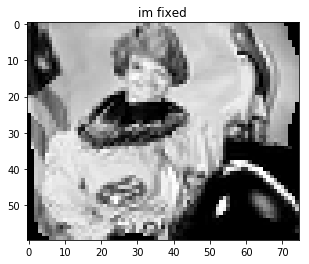

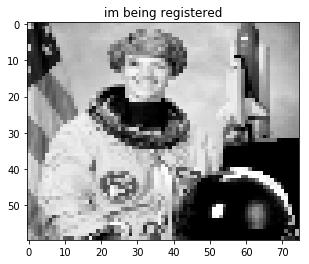

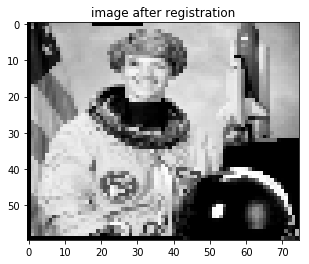

In [3]:
# now do registration

"""
    bfgs src: https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fmin_bfgs.html
"""

SIGMA=10
SAMP_SPACE=12
L2_REG=.1

def ssd_nonrigid(params, im_fixed, im_moving, 
                 im_deformer, show_figs=False): 
    
    params = np.array(params)
    
    w_x = params[: int(len(params) / 2)]
    w_y = params[int(len(params) / 2):]

    w_x = np.reshape(np.array(w_x), (len(w_x), 1))
    w_y = np.reshape(np.array(w_y), (len(w_y), 1))
    
    assert len(w_x) == len(w_y)
    
    im_deformer = ImageDeformer(im_moving, samp_space=SAMP_SPACE, sigma=SIGMA)
    
    im_deformer.w_x = w_x 
    im_deformer.w_y = w_y 
    
    im_mov_regis = im_deformer.apply_deformation_from_wts()
    
    row, col = im_mov_regis.shape
    ssd = (np.sum(np.square(im_fixed - im_mov_regis)) + 
           L2_REG * (np.linalg.norm(w_x) + np.linalg.norm(w_y)))
    
    if True:
        plt.figure(1)
        plt.imshow(im_fixed, cmap='gray')
        plt.title('im fixed')
        
        plt.figure(2)
        plt.imshow(im_deformer.image, cmap='gray')
        plt.title('image being deformed')
        
        plt.figure(3)
        plt.imshow(im_mov_regis, cmap='gray')
        plt.title('deformed image')
    
    print('param shape: {}, sum: {}'.format(params.shape, np.sum(params)))
    print('ssd: {}'.format(ssd))
    
    return ssd


# def im_register_nonrigid(im_fixed, im_moving, show_figs=False):
    
im_mov_deformer = ImageDeformer(im_moving, samp_space=SAMP_SPACE, sigma=SIGMA)
w_x = im_mov_deformer.w_x
w_y = im_mov_deformer.w_y

# params_init = np.concatenate((w_x, w_y)).flatten()
params_init = np.zeros(( 2 * len(w_x), ))
print(w_x.shape, params_init.shape)

# options={'epsilon': .1}
options = {}

error_function = lambda x:ssd_nonrigid(
    x, im_fixed, im_moving, im_mov_deformer, True)

# params_optimized = scipy.optimize.minimize(
#     error_function, params_init,
#     method='BFGS', options=options, jac='2-point')
# print(params_optimized)

# params = params_optimized.x

param_out, f_min, jac_opt, hess_inv_opt, fun_calls, grad_calls, _ = scipy.optimize.fmin_bfgs(
    ssd_nonrigid, params_init,
    args=(im_fixed, im_moving, im_mov_deformer, True),
    epsilon=.1,
    disp=True, full_output=True,
)

print(fun_calls, grad_calls)
print(jac_opt, hess_inv_opt)

params = param_out

w_x = params[: int(len(params) / 2)]
w_y = params[int(len(params) / 2):]

w_x = np.reshape(np.array(w_x), (len(w_x), 1))
w_y = np.reshape(np.array(w_y), (len(w_y), 1))

im_mov_deformer.w_x = w_x
im_mov_deformer.w_y = w_y

im_registered = im_mov_deformer.apply_deformation_from_wts()
    
#     return im_registered

# im_registered = im_register_nonrigid(
#     im_fixed, im_moving, show_figs=True
# )


plt.figure(1)
plt.title('target (transformed)')
plt.imshow(im_fixed, cmap='gray')
plt.title('im fixed')

plt.figure(2)
plt.title('moving (orig)')
plt.imshow(im_moving, cmap='gray')
plt.title('im being registered')

plt.figure(3)
plt.title('registered')
plt.imshow(im_registered, cmap='gray')
plt.title('image after registration')
plt.show()

In [51]:
w_x = imdeform_init.w_x
w_y = imdeform_init.w_y

params = list(np.concatenate((w_x, w_y)).flatten())

w_x_2 = params[: int(len(params) / 2)]
w_y_2 = params[int(len(params) / 2):]

w_x_2 = np.reshape(np.array(w_x_2), (len(w_x_2), 1))
w_y_2 = np.reshape(np.array(w_y_2), (len(w_y_2), 1))

assert np.allclose(w_x, w_x_2)
assert np.allclose(w_y, w_y_2)
assert len(w_x_2) == len(w_y_2)